# Task 3: Understand human gesture and body language based on your own built dataset and model

## 1. Do literature search on dataset building and other deep learning based models applied on gesture recognition. Comment on their applications and benefits.

## 2. In the earlier two tasks, you have learned how to do the gesture classification task using the given dataset. Now, you need to collect data by yourself and build your own dataset. The dataset is not limited to gestures. Postures and behavior are encouraged. Please place your data referring to the format of the given dataset. For good performance, the number of data in each class is recommended over 50. For the number of classes, it is better to have more than 3.

## 3. Design your own neural network architecture. Fully connected or convolutional layers used in the first two tasks is acceptable. But you are encouraged to learn more deep learning models and achieve it as possible as you can.

## 3. Write down the problems you encountered during the experiment, the solutions, and your experiences.

In [1]:
import cv2
import numpy as np
import os
import itertools
import torch.utils.data as utils_data

In [12]:
def processSkinImage(filePath, resize_HW=48):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    # cv2.imshow("", image_output)
    # cv2.waitKey(0)
    return image_output

In [13]:
path = './task3'
path_processed = './task3_process/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        # print("Processing file:", currentPath)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './task3_process/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

In [14]:
Image = []
path_images = './task3_process/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        Image.append(cv2.imread(currentPath)[:, :, 0])
Image = np.array(Image)
dataset_size, H, W = Image.shape
# # for FCNN model, the image need to be stretched into one dimension: (b, h, w)->(b, h*w)
# Image = Image.reshape(dataset_size, -1)


Label = []
path_labels = './task3_process/labels'
for file in os.listdir(path_labels):
    Label.append(np.loadtxt(os.path.join(path_labels, file)))
Label = np.array(list(itertools.chain.from_iterable(Label)))
num_classes = int(np.max(Label))+1

In [15]:
print('Image shape:', Image.shape)
print('Label shape:', Label.shape)

Image shape: (1185, 256, 256)
Label shape: (1185,)


In [6]:
import torch
import torch.nn.functional as F
import torch.utils.data as utils_data
class ConvModule(torch.nn.Module):
    def __init__(self,input_channel=1):
        super(ConvModule, self).__init__()
        
        self.conv = torch.nn.Sequential(
            # (batch_size, input_channel, H, W)->(batch_size, 32, H-2, W-2)
            torch.nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 32, H-2, W-2)->(batch_size, 64, H-4, W-4)
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 64, H-4, W-4)->(batch_size, 128, H-6, W-6)
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True)
        )
        #(128)->(4)
        self.fc = torch.nn.Linear(128, 5)

    def forward(self, X):
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X=X.unsqueeze(1)
        # X = X.to(device)
        out = self.conv(X)  # (batch_size, 128, H - 6, W - 6)
        # 48-2-2-2=42
        out = F.avg_pool2d(out, 42)  # (batch_size, 128, 1, 1)
        # (batch_size, 128, 1, 1)->(batch_size, 128)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [7]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvModule()
model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [8]:
dataset = utils_data.TensorDataset(torch.Tensor(Image), torch.LongTensor(Label))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=8, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=8, shuffle=True)
print('Data is ready!')

Data is ready!


epoch=0	train loss=1.447074	train accuracy=0.435	test accuracy=0.553
epoch=1	train loss=1.181425	train accuracy=0.643	test accuracy=0.688
epoch=2	train loss=0.976711	train accuracy=0.801	test accuracy=0.886
epoch=3	train loss=0.817323	train accuracy=0.870	test accuracy=0.844
epoch=4	train loss=0.644973	train accuracy=0.918	test accuracy=0.333
epoch=5	train loss=0.512930	train accuracy=0.932	test accuracy=0.435
epoch=6	train loss=0.464993	train accuracy=0.928	test accuracy=0.249
epoch=7	train loss=0.377679	train accuracy=0.957	test accuracy=0.747
epoch=8	train loss=0.271741	train accuracy=0.972	test accuracy=0.684
epoch=9	train loss=0.249464	train accuracy=0.962	test accuracy=0.430
epoch=10	train loss=0.227945	train accuracy=0.967	test accuracy=0.532
epoch=11	train loss=0.222180	train accuracy=0.975	test accuracy=0.878
epoch=12	train loss=0.160467	train accuracy=0.972	test accuracy=0.983
epoch=13	train loss=0.126535	train accuracy=0.985	test accuracy=0.983
epoch=14	train loss=0.140518	t

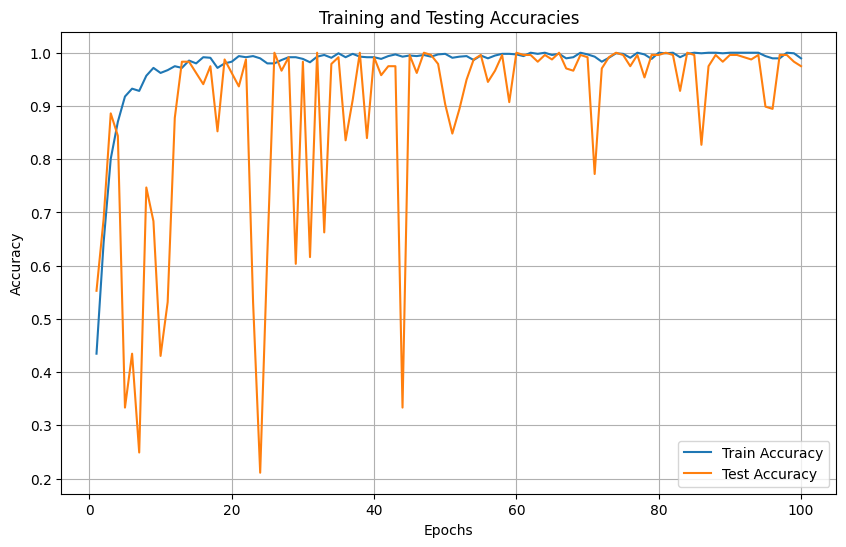

In [9]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(100):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task3_trained_models/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task3_trained_models/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()


resnet

In [2]:
import os
import torch.nn.functional as F
import torch.utils.data as utils_data
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

In [3]:
def processSkinImage(filePath, resize_HW=128):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    # cv2.imshow("", image_output)
    # cv2.waitKey(0)
    return image_output

In [4]:
path = './task3'
path_processed = './task3_process/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        # print("Processing file:", currentPath)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './task3_process/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

In [12]:
Image = []
path_images = './task3_process/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        Image.append(cv2.imread(currentPath)[:, :, 0])
Image = np.array(Image)
dataset_size, H, W = Image.shape
# # for FCNN model, the image need to be stretched into one dimension: (b, h, w)->(b, h*w)
# Image = Image.reshape(dataset_size, -1)


Label = []
path_labels = './task3_process/labels'
for file in os.listdir(path_labels):
    Label.append(np.loadtxt(os.path.join(path_labels, file)))
Label = np.array(list(itertools.chain.from_iterable(Label)))
num_classes = int(np.max(Label))+1

In [13]:
#残差网络块
#每个残差块都是两层
#默认3*3卷积下padding为1，则大小不会变化，如变化则是步长引起的。
class ResidualBlock(torch.nn.Module):
    def __init__(self, nin, nout, size, stride=1, shortcut=True):
        super(ResidualBlock, self).__init__()
        #两层卷积层
        #不同步长只有第一层卷积层不同
        self.block1 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, padding=1),
                                          torch.nn.BatchNorm2d(nout),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.Conv2d(nout, nout, size, 1, padding=1),
                                          torch.nn.BatchNorm2d(nout))
        self.shortcut = shortcut
        #解决通道数变化以及步长不为1引起的图片大小的变化
        self.block2 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, 1),
                                          torch.nn.BatchNorm2d(nout))
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, input):
        x = input
        
        out = self.block1(x)
        '''''若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道'''
        if self.shortcut:
            out = x + out
        else:
            out = out + self.block2(x)
        out = self.relu(out)
        return out


#定义给定的残差结构
class resnet(torch.nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.block = torch.nn.Sequential(torch.nn.Conv2d(1, 64, 3, stride=1, padding=1),
                                         torch.nn.BatchNorm2d(64),
                                         torch.nn.ReLU())
        #t表示2个相同的残差块,每个残差块两个卷积
        self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
        self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
        self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
        self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)

        self.avgp = torch.nn.AvgPool2d(8)
        self.exit = torch.nn.Linear(512, 5)

    def make_layer(self, in1, out1, ksize, stride, t):
        layers = []
        for i in range(0, t):
            if i == 0 and in1 != out1:
                layers.append(ResidualBlock(in1, out1, ksize, stride, None))
            else:
                layers.append(ResidualBlock(out1, out1, ksize, 1, True))
        return torch.nn.Sequential(*layers)

    def forward(self, input):
        input=input.unsqueeze(1)
        x = self.block(input)  # 输出维度 64 * 64 * 64    C * H * W
        x = self.d1(x)  # 输出维度 64 * 54 * 54
        x = self.d2(x)  # i=0 步长为2，输出维度128 * 32 * 32
        x = self.d3(x)  # i=0 步长为2，输出维度256 * 16 * 16
        x = self.d4(x)  # i=0 步长为2，输出维度512 * 8 * 8
        x = F.adaptive_avg_pool2d(x, (1,1))
        #将张量out从shape batchx512x1x1 变为 batch x512
        x = x.squeeze()
        output = self.exit(x)
        return output



In [14]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet()
model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [15]:
dataset = utils_data.TensorDataset(torch.Tensor(Image), torch.LongTensor(Label))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=16, shuffle=True)
print('Data is ready!')

Data is ready!


epoch=0	train loss=0.913724	train accuracy=0.635	test accuracy=0.422
epoch=1	train loss=0.253202	train accuracy=0.935	test accuracy=0.363
epoch=2	train loss=0.115571	train accuracy=0.972	test accuracy=0.658
epoch=3	train loss=0.045033	train accuracy=0.991	test accuracy=0.983
epoch=4	train loss=0.034733	train accuracy=0.997	test accuracy=0.700
epoch=5	train loss=0.015771	train accuracy=0.998	test accuracy=0.992
epoch=6	train loss=0.030120	train accuracy=0.993	test accuracy=0.367
epoch=7	train loss=0.038491	train accuracy=0.991	test accuracy=0.886
epoch=8	train loss=0.023503	train accuracy=0.996	test accuracy=0.983
epoch=9	train loss=0.008547	train accuracy=1.000	test accuracy=0.983
epoch=10	train loss=0.050233	train accuracy=0.988	test accuracy=0.979
epoch=11	train loss=0.007198	train accuracy=0.999	test accuracy=0.738
epoch=12	train loss=0.004490	train accuracy=1.000	test accuracy=0.992
epoch=13	train loss=0.009078	train accuracy=0.999	test accuracy=0.603
epoch=14	train loss=0.142384	t

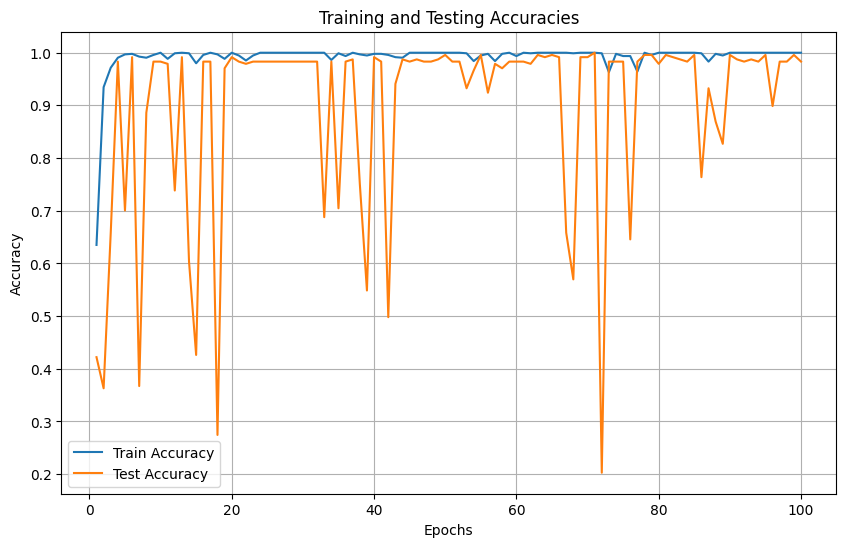

In [16]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(100):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task3_trained_models_resnet/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task3_trained_models_resnet/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()

AlexNet

In [3]:
def processSkinImage(filePath, resize_HW=227):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    # cv2.imshow("", image_output)
    # cv2.waitKey(0)
    return image_output

In [4]:
path = './task3'
path_processed = './task3_process/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        # print("Processing file:", currentPath)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './task3_process/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

In [5]:
Image = []
path_images = './task3_process/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        Image.append(cv2.imread(currentPath)[:, :, 0])
Image = np.array(Image)
dataset_size, H, W = Image.shape
# # for FCNN model, the image need to be stretched into one dimension: (b, h, w)->(b, h*w)
# Image = Image.reshape(dataset_size, -1)


Label = []
path_labels = './task3_process/labels'
for file in os.listdir(path_labels):
    Label.append(np.loadtxt(os.path.join(path_labels, file)))
Label = np.array(list(itertools.chain.from_iterable(Label)))
num_classes = int(np.max(Label))+1

In [6]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            torch.nn.Conv2d(96, 256, 5, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            torch.nn.Conv2d(256, 384, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 384, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 256, 3, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1024, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 5),
        )

    def forward(self, img):
        img = img.unsqueeze(1)
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [7]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [8]:
dataset = utils_data.TensorDataset(torch.Tensor(Image), torch.LongTensor(Label))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=16, shuffle=True)
print('Data is ready!')

Data is ready!


epoch=0	train loss=17.108882	train accuracy=0.442	test accuracy=0.802
epoch=1	train loss=0.340443	train accuracy=0.886	test accuracy=0.941
epoch=2	train loss=0.103433	train accuracy=0.967	test accuracy=1.000
epoch=3	train loss=0.114823	train accuracy=0.977	test accuracy=0.996
epoch=4	train loss=0.231108	train accuracy=0.941	test accuracy=0.789
epoch=5	train loss=0.419749	train accuracy=0.899	test accuracy=0.992
epoch=6	train loss=0.424426	train accuracy=0.936	test accuracy=0.975
epoch=7	train loss=0.152013	train accuracy=0.962	test accuracy=1.000
epoch=8	train loss=0.026677	train accuracy=0.991	test accuracy=0.996
epoch=9	train loss=0.189435	train accuracy=0.966	test accuracy=0.755
epoch=10	train loss=0.199610	train accuracy=0.977	test accuracy=1.000
epoch=11	train loss=0.025252	train accuracy=0.993	test accuracy=1.000
epoch=12	train loss=0.000118	train accuracy=1.000	test accuracy=1.000
epoch=13	train loss=0.000834	train accuracy=0.999	test accuracy=1.000
epoch=14	train loss=0.000245	

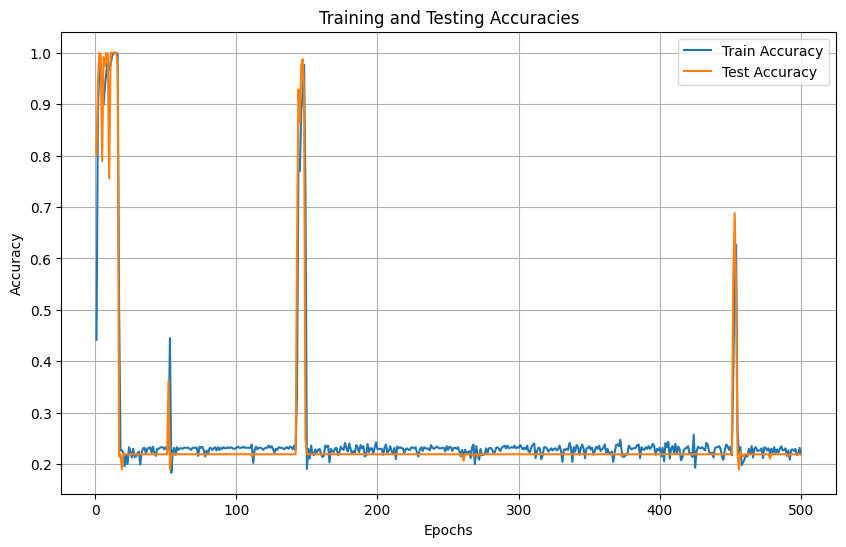

In [31]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(500):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task3_trained_models_alexnet/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task3_trained_models_alexnet/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()

epoch=0	train loss=2.388081	train accuracy=0.210	test accuracy=0.194
epoch=1	train loss=1.607380	train accuracy=0.211	test accuracy=0.194
epoch=2	train loss=1.603706	train accuracy=0.238	test accuracy=0.194
epoch=3	train loss=1.603900	train accuracy=0.237	test accuracy=0.194
epoch=4	train loss=1.603805	train accuracy=0.238	test accuracy=0.194
epoch=5	train loss=1.603624	train accuracy=0.239	test accuracy=0.194
epoch=6	train loss=1.603024	train accuracy=0.238	test accuracy=0.194
epoch=7	train loss=1.607673	train accuracy=0.239	test accuracy=0.194
epoch=8	train loss=1.606574	train accuracy=0.238	test accuracy=0.194
epoch=9	train loss=1.604281	train accuracy=0.238	test accuracy=0.194
epoch=10	train loss=1.607184	train accuracy=0.238	test accuracy=0.194
epoch=11	train loss=1.604344	train accuracy=0.237	test accuracy=0.194
epoch=12	train loss=1.603151	train accuracy=0.238	test accuracy=0.194
epoch=13	train loss=1.603721	train accuracy=0.238	test accuracy=0.194
epoch=14	train loss=1.602397	t

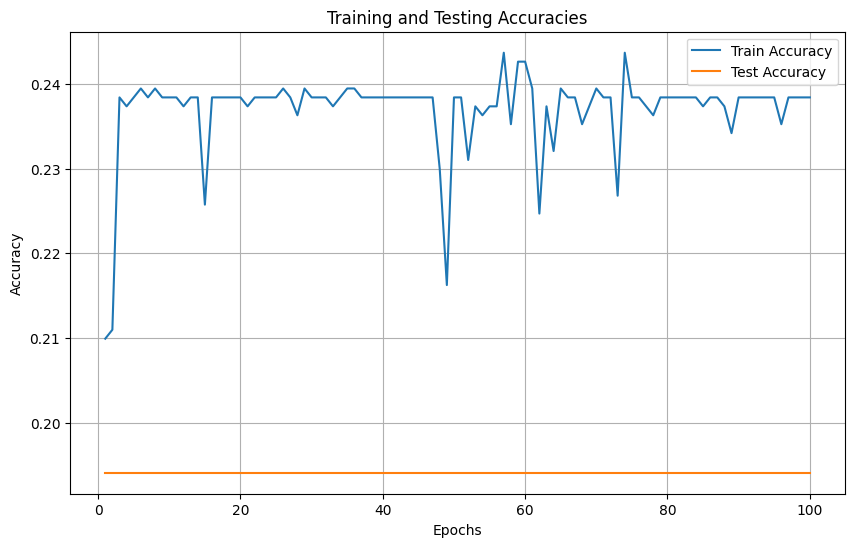

In [9]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(100):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task3_trained_models_alexnet100/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task3_trained_models_alexnet100/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()